# 波士顿房价预测

In [1]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

数据标准化, axis=0，那么输出矩阵是1行，求每一列的平均（按照每一行去求平均）；axis=1，输出矩阵是1列，求每一行的平均（按照每一列去求平均）。

In [4]:
mean = train_data.mean(axis=0)  # axis=0 
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [5]:
mean.shape

(13,)

模型定义

In [6]:
from keras import models, layers


def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


K折验证

In [8]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)   # verbose = 0 静默模
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [9]:
all_scores

[2.054196007180922, 2.18858540176165, 2.9994579707041824, 2.424615839920422]

保存每折的验证结果

In [10]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print("processing fold #", i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0
    )
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [11]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

<Figure size 640x480 with 1 Axes>

In [13]:
len(average_mae_history)

500

In [14]:
average_mae_history

[4.238724838389029,
 3.1771945504858943,
 2.969516355212372,
 2.664558481461931,
 2.620112704758597,
 2.5328844950930907,
 2.4815707737856574,
 2.5513625782315095,
 2.479768777837848,
 2.5299457288024447,
 2.468961446592123,
 2.506539266888458,
 2.635285319668231,
 2.4537780426516393,
 2.49405038238752,
 2.551144213369577,
 2.4442369394963332,
 2.416406000014579,
 2.392802322264945,
 2.4252072714342927,
 2.3319613142768936,
 2.395446528302561,
 2.431829744046277,
 2.4272165463702513,
 2.2879491182837155,
 2.480060302385009,
 2.378130184541835,
 2.3594847811330664,
 2.4565259973601536,
 2.387929428922068,
 2.4285580923061563,
 2.5161072712133423,
 2.4840713833818344,
 2.59160307728418,
 2.4247721197581527,
 2.4016989929841297,
 2.4251356549782326,
 2.430362887901835,
 2.4645442573150786,
 2.655929474547358,
 2.4216832453661628,
 2.589650615607158,
 2.3799275478514113,
 2.4643603339053617,
 2.310291050684334,
 2.3709272264253975,
 2.480041683310329,
 2.339896264642772,
 2.416107162390605

绘制yanzheng分数，删除前10个点

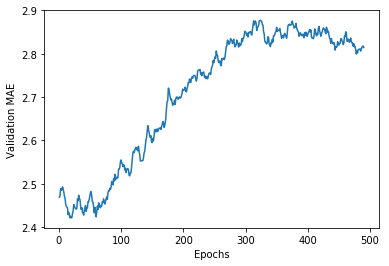

In [15]:
def smooth_curve(points, factor=0.9):
    smooth_points = []
    for point in points:
        if smooth_points:
            previous = smooth_points[-1]
            smooth_points.append(previous * factor + point * (1 - factor))
        else:
            smooth_points.append(point)
    return smooth_points


smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


In [16]:
len(smooth_mae_history)

490

In [17]:
smooth_mae_history

[2.468961446592123,
 2.4727192286217567,
 2.488975837726404,
 2.4854560582189276,
 2.486315490635787,
 2.492798362909166,
 2.4879422205678825,
 2.480788598512552,
 2.4719899708877913,
 2.4673117009424415,
 2.4537766622758865,
 2.447943648878554,
 2.4463322583953264,
 2.4444206871928187,
 2.4287735303019087,
 2.4339022075102186,
 2.4283250052133805,
 2.421440982805349,
 2.4249494842608295,
 2.4212474787269533,
 2.4219785400848735,
 2.43139141319772,
 2.4366594102161314,
 2.4521537769229362,
 2.449415611206458,
 2.444643949384225,
 2.442693119943626,
 2.441460096739447,
 2.44376851279701,
 2.464984608972045,
 2.460654472611457,
 2.473554086911027,
 2.4641914330050656,
 2.4642083230950953,
 2.4488165958540193,
 2.4410276589111572,
 2.4449290613510746,
 2.434425781680244,
 2.4325939197512803,
 2.42763816528073,
 2.4388295957771557,
 2.444971511401241,
 2.449904681019748,
 2.4359229656556685,
 2.4429411167282074,
 2.4448156024372807,
 2.458997792242464,
 2.458542585580256,
 2.46474322111074